# Churn Modelling
Source: https://www.kaggle.com/shrutimechlearn/churn-modelling

## Data Analysis and Preparation

In [1]:
# Import modules
from google.colab import files
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

np.set_printoptions(formatter = {'float': '{: 0.1f}'.format})

In [2]:
# Uploading files

# Upload Churn_Modelling.csv
uploaded = files.upload()

Saving Churn_Modelling.csv to Churn_Modelling.csv


In [3]:
# Loading the dataset

# Load CSV dataset into data frame
df = pd.read_csv('Churn_Modelling.csv', delimiter=',')

## EDA (Exploratory Data Analysis)

In [4]:
# Display instance count
print("Number of instances (rows): %s" % df.shape[0])

# Display feature count
print("Number of features (columns): %s" % df.shape[1])

Number of instances (rows): 10000
Number of features (columns): 14


In [5]:
# Check for missing values
df.isnull().values.any()

False

In [6]:
# Display summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Data Preparation

In [7]:
# Drop irrelevant features
df.drop(columns = ['RowNumber', 'CustomerId', 'Surname'], inplace = True, errors = 'ignore')

In [8]:
# Convert camel case to snake case
def camel2snake(str):
  return re.sub(r'(?<!^)(?=[A-Z])', '_', str).lower()

# Rename features
df.rename(columns = {'NumOfProducts': 'ProductCount', 'HasCrCard': 'HasCreditCard', 'IsActiveMember': 'Active'}, inplace = True, errors = 'ignore')
df.rename(columns = camel2snake, inplace = True, errors = 'ignore')

In [9]:
# Cleaning features

# Convert geography feature
if df['geography'].dtype == np.object:
  df['geography'].replace(['France', 'Germany', 'Spain'], [0, 1, 2], inplace = True)

# Convert gender feature
if df['gender'].dtype == np.object:
  df['gender'].replace(['Male', 'Female'], [0, 1], inplace = True)

In [10]:
# Inspect data
df.head()

,credit_score,geography,gender,age,tenure,balance,product_count,has_credit_card,active,estimated_salary,exited
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0


## Visualization of Input



In [11]:
# Display feature statistics
df.describe()

,credit_score,geography,gender,age,tenure,balance,product_count,has_credit_card,active,estimated_salary,exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.746300,0.454300,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,0.827529,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,0.000000,0.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,1.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


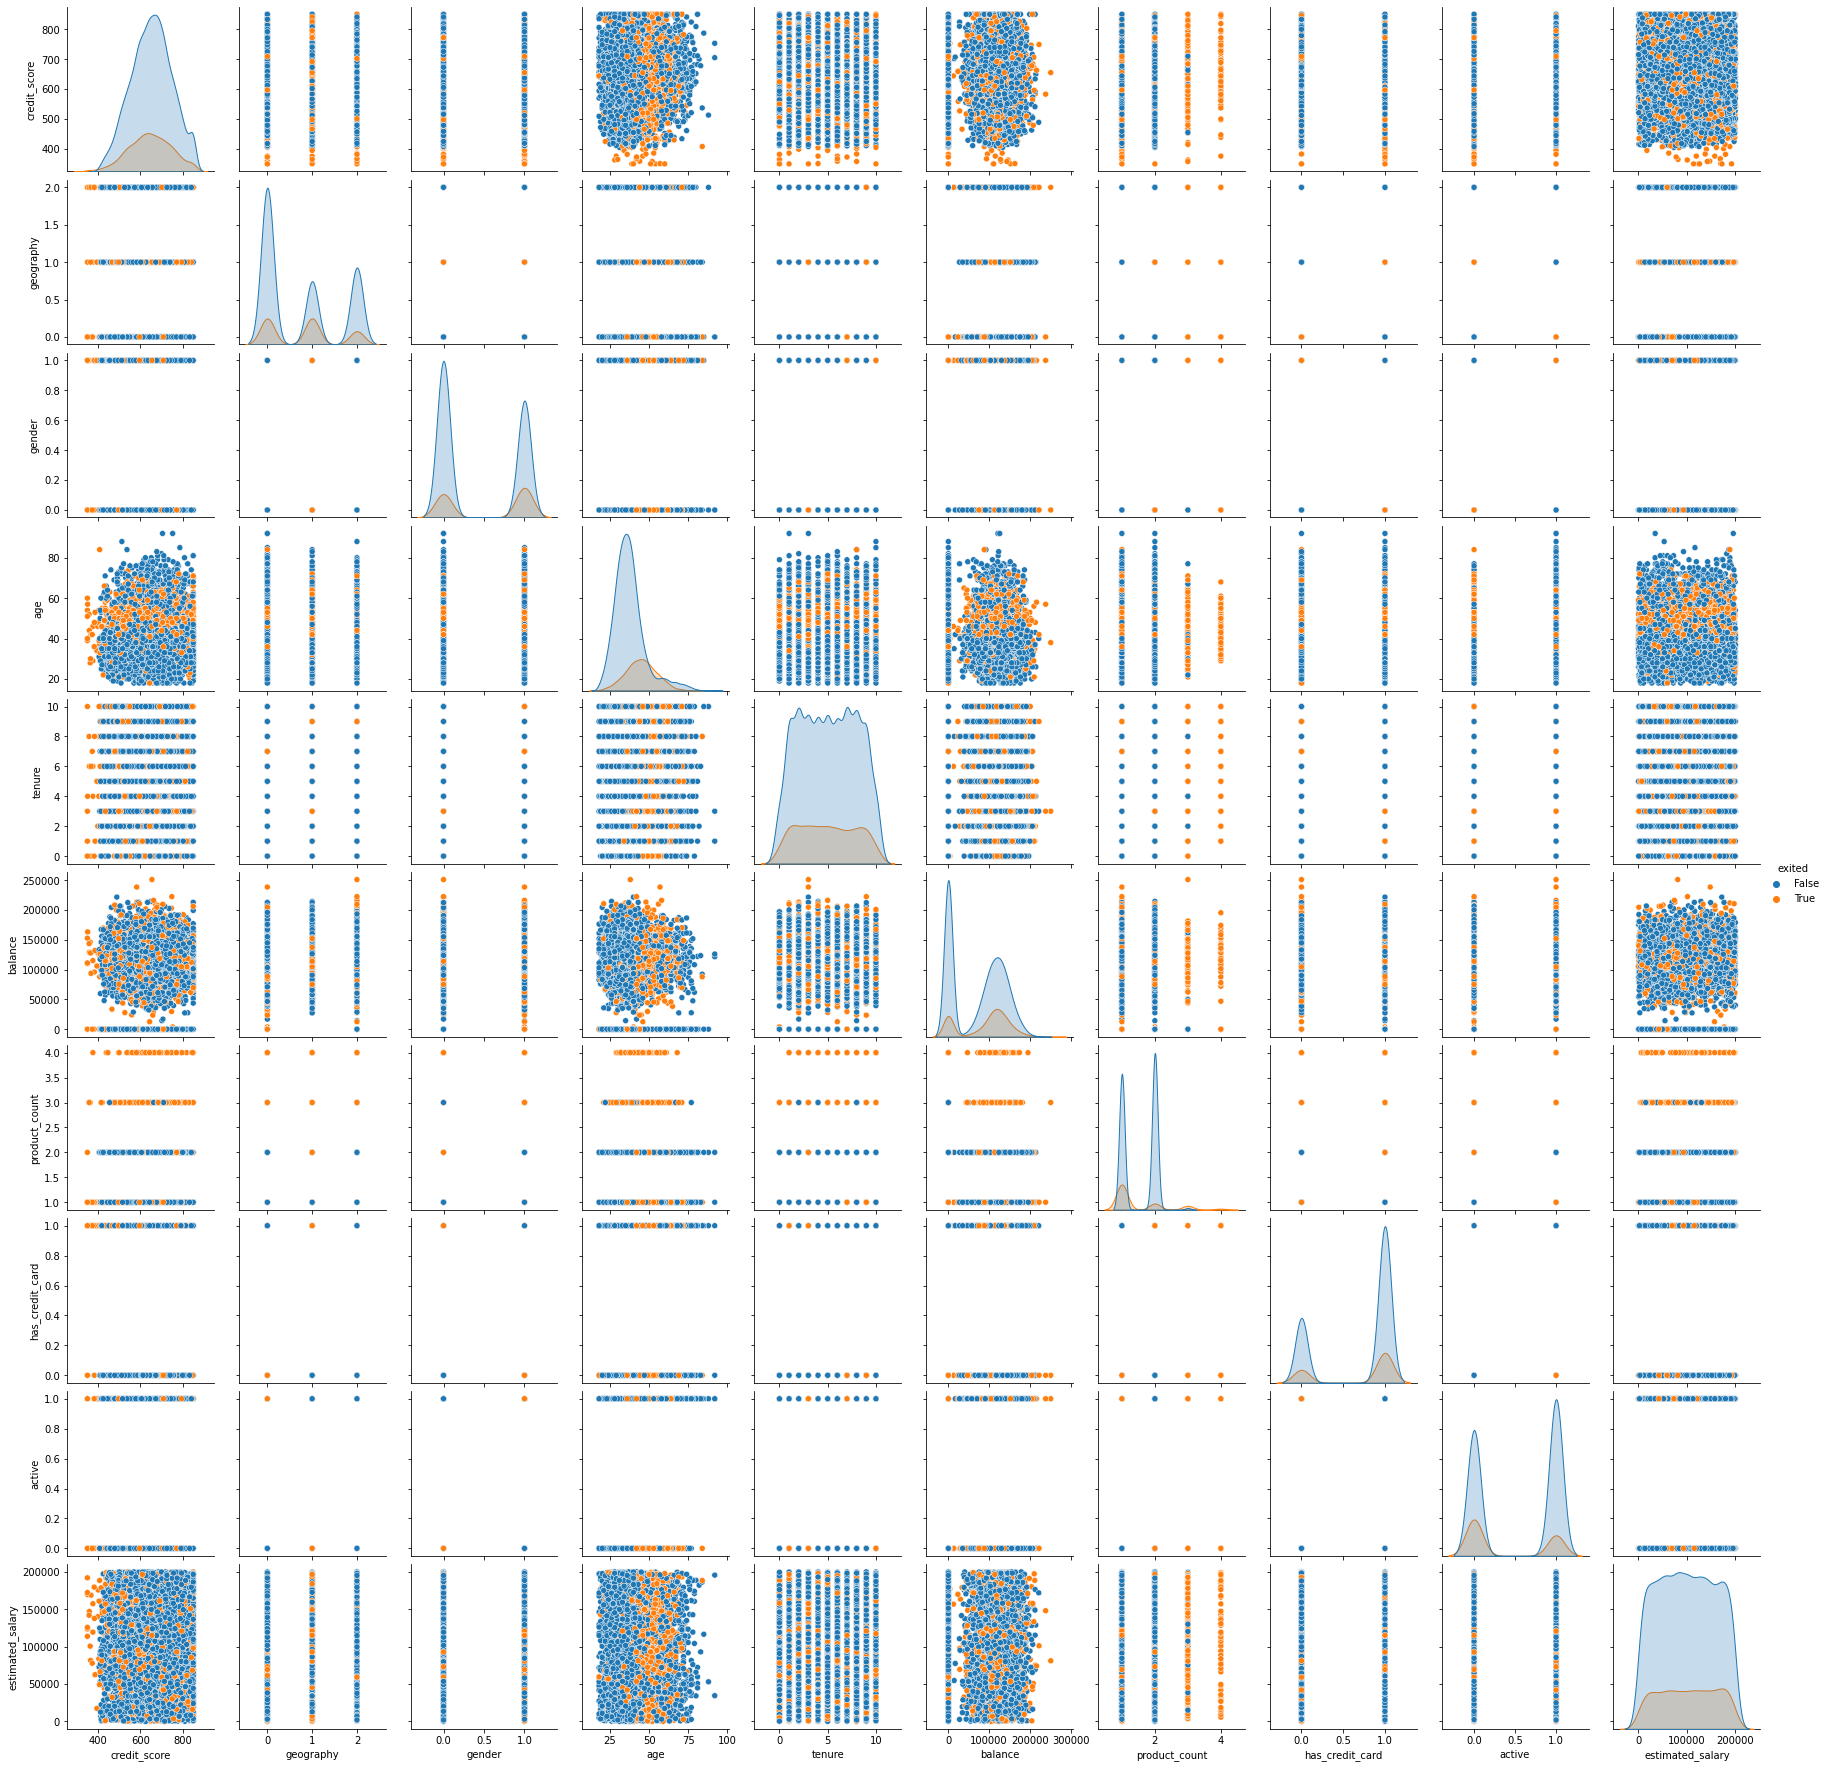

In [12]:
# Visualize correlations between input features and output label
g = sns.pairplot(df, hue = 'exited')
g.legend.get_title().set_text('exited')
g.legend.get_texts()[0].set_text('False')
g.legend.get_texts()[1].set_text('True')

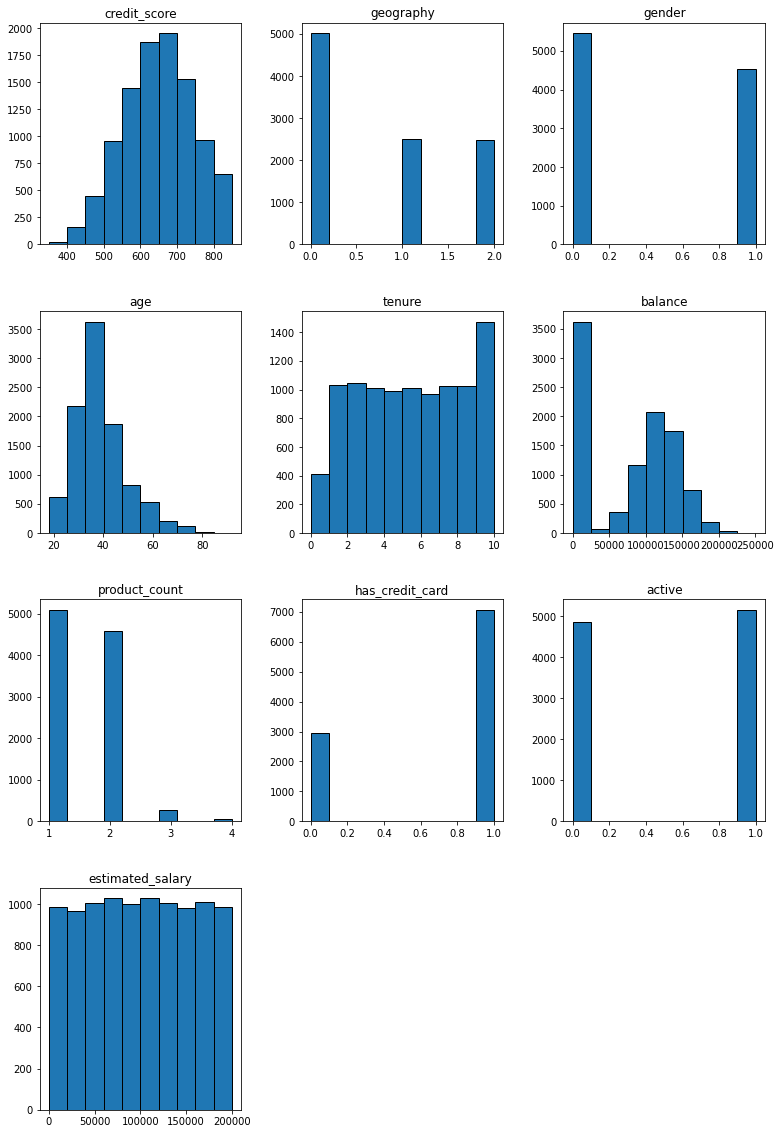

In [13]:
# Visualize input feature distributions
hist = df.drop('exited', axis = 'columns').hist(grid = False, figsize = (13, 20), ec = 'k')

## Visualization of Output

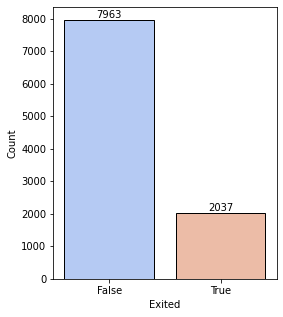

In [14]:
# Visualize output label distribution
plt.figure(figsize = (4, 5))
ax = sns.countplot(x = 'exited', data = df, palette = 'coolwarm', ec = 'k')
xt = plt.xticks([0, 1], ['False', 'True'])
xl = plt.xlabel('Exited')
yl = plt.ylabel('Count')

# Add count annotations
for rec in ax.patches:
    ax.annotate(format(rec.get_height(), '.0f'), (rec.get_x() + rec.get_width() / 2.0, rec.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize = 10)

## Training and Validation

In [15]:
# Shuffle rows
df = df.sample(frac = 1).reset_index(drop = True)

# Convert to NumPy matrix
dataset = df.values

# Separate input and output
X = df.drop('exited', axis = 'columns').values
Y = df['exited'].values

In [16]:
# Index for 20%
index = int(0.2 * len(dataset[:, 0]))

# Split into training (80%) and validation (20%) sets
XTRAIN = X[index:, :]
YTRAIN = Y[index:]
XVALID = X[:index, :]
YVALID = Y[:index]

## Data Normalization

In [17]:
# Mean normalization
min = XTRAIN.min(axis = 0)
max = XTRAIN.max(axis = 0)
mean = XTRAIN.mean(axis = 0)
XTRAIN = (XTRAIN - mean) / (max - min)
XVALID = (XVALID - mean) / (max - min)

# Rescaling
Ymax = YTRAIN.max()
YTRAIN = YTRAIN / Ymax
YVALID = YVALID / Ymax

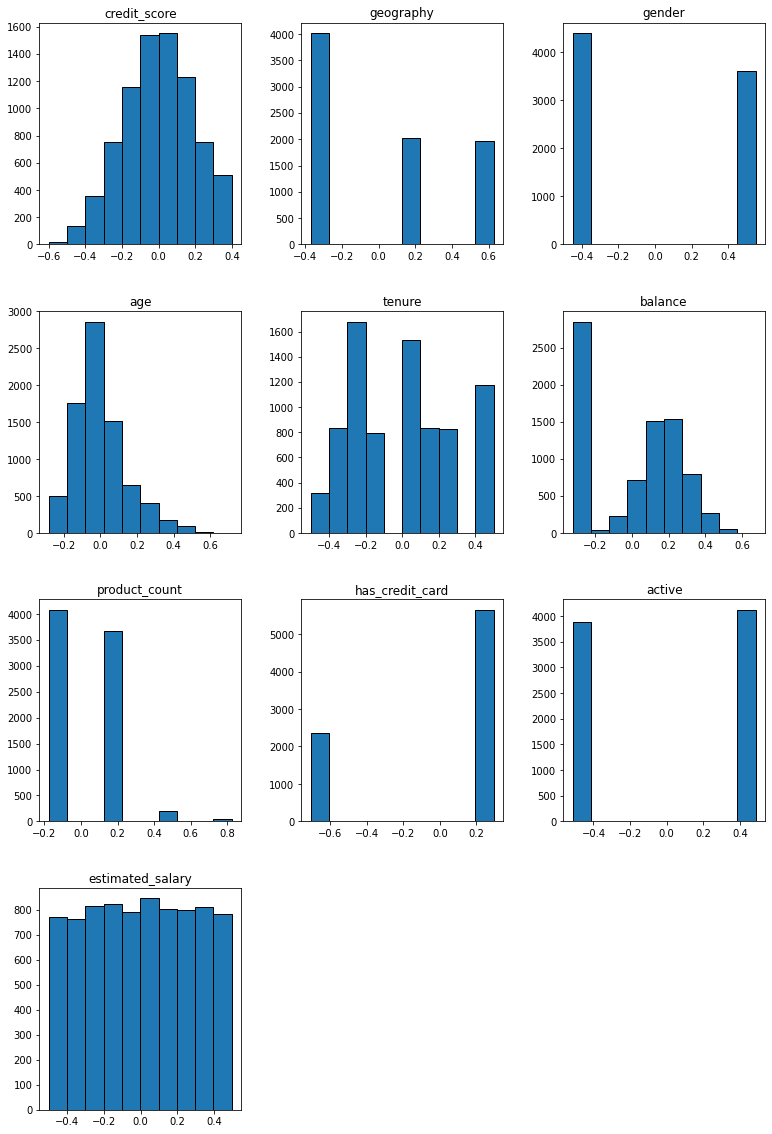

In [18]:
# Visualize input feature distribution after normalization
dfx = pd.DataFrame(data = XTRAIN)
dfx.columns = df.drop('exited', axis = 'columns').columns
hist = dfx.hist(grid = False, figsize = (13, 20), ec = 'k')